In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
import scipy
import xgboost as xgb
import unicodedata
import jieba
import jieba.posseg as pseg
jieba.enable_paddle()
%matplotlib inline

Paddle enabled successfully......


In [2]:
df = pd.read_csv("train_classifier_2_balance.txt", sep='\t', header=None, names=["label", "feature", "text"])

In [3]:
df = pd.concat([df, df['feature'].str.split(' ', expand=True)], axis=1)
del df['feature']

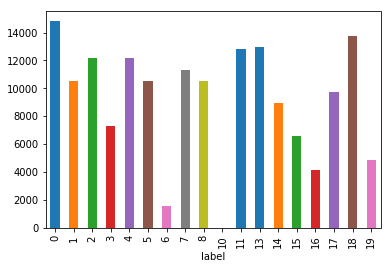

In [4]:
df.groupby("label")['text'].count().plot.bar()

In [5]:
df['label'].value_counts()

0     14852
10    14598
18    13787
13    12976
11    12976
2     12165
4     12165
6     11354
7     11354
1     10543
5     10543
8     10543
17     9732
14     8921
3      7299
15     6600
19     5677
16     4167
Name: label, dtype: int64

In [6]:
def words(s):
    s = str(s)
    s = unicodedata.normalize('NFKC', s).lower()
    return [word for word, pos in pseg.cut(s, use_paddle=True) if pos != 'w']

def clean(s):
    return ' '.join(words(s))

In [7]:
df['text_seg'] = df['text'].apply(clean)

In [8]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(df['text_seg'].unique())
text_trans = count_vect.transform(df['text_seg'].values)

In [9]:
labels = df['label'].values
X = scipy.sparse.hstack((df[list(range(81))].values.astype(float), text_trans))
y = labels

In [12]:
len(set(y))

18

In [16]:
X_train,X_valid,y_train,y_valid = train_test_split(X, y, test_size=0.33, random_state=42)
params = {
    'booster': 'gbtree',
    'objective': 'multi:softmax',  # 多分类的问题
    'num_class': 20,               # 类别数，与 multisoftmax 并用
    'gamma': 0.1,                  # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
    'max_depth': 10,               # 构建树的深度，越大越容易过拟合
    'lambda': 2,                   # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
    'subsample': 0.7,              # 随机采样训练样本
    'colsample_bytree': 0.7,       # 生成树时进行的列采样
    'min_child_weight': 3,
    'silent': 1,                   # 设置成1则没有运行信息输出，最好是设置为0.
    'eta': 0.007,                  # 如同学习率
    'seed': 1000,
}
dtrain = xgb.DMatrix(X_train, label=y_train)
watchlist = [(dtrain,'train')]
num_round = 100
early_stopping_rounds = 10

bst = xgb.train(params, dtrain, num_round, watchlist, early_stopping_rounds=early_stopping_rounds)

[0]	train-merror:0.00804
Will train until train-merror hasn't improved in 10 rounds.
[1]	train-merror:0.00857
[2]	train-merror:0.00890
[3]	train-merror:0.00928
[4]	train-merror:0.01021
[5]	train-merror:0.01040
[6]	train-merror:0.01027
[7]	train-merror:0.00981
[8]	train-merror:0.00966
[9]	train-merror:0.00998
[10]	train-merror:0.01023
Stopping. Best iteration:
[0]	train-merror:0.00804



In [17]:
# make predictions
expected = y_valid
dtest = xgb.DMatrix(X_valid)
predicted = bst.predict(dtest)

In [18]:
print(metrics.classification_report(expected, predicted))
#print(metrics.confusion_matrix(expected, predicted))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93      4921
           1       0.99      1.00      0.99      3500
           2       0.99      1.00      0.99      3990
           3       0.98      1.00      0.99      2433
           4       0.99      1.00      1.00      4001
           5       0.99      1.00      1.00      3432
           6       0.99      1.00      0.99      3776
           7       0.99      1.00      1.00      3782
           8       0.99      1.00      0.99      3530
          10       0.99      1.00      1.00      4800
          11       0.99      1.00      1.00      4286
          13       0.99      1.00      1.00      4286
          14       0.99      1.00      1.00      2841
          15       0.95      1.00      0.98      2133
          16       1.00      1.00      1.00      1416
          17       0.99      1.00      0.99      3200
          18       0.99      1.00      1.00      4590
          19       0.97    